Imputing Missing Values and Below LOD
===

<div class="alert alert-block alert-info"> 
Author: Nathan A. Mahynski
    
Date: 2023/08/23
    
Description: Illustrate different ways to impute missing or bad data and implement this in pipelines.
    
</div>

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/pychemauth.git --depth 1
    !cd pychemauth; pip3 install .; cd ..

try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")
    
import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import imblearn
import sklearn

from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

pychemauth: 0.0.0b3
imblearn  : 0.11.0
json      : 2.0.9
sklearn   : 1.3.0
matplotlib: 3.7.2
watermark : 2.4.3
pandas    : 2.0.3
numpy     : 1.24.4



Load some Data
---

<div class="alert alert-block alert-info">
Let's load some sample data, then purposefully corrupt it so that we can try to reconstruct it with various methods.
</div>

In [4]:
# Get some data from the pychemauth repository
loc = 'https://raw.githubusercontent.com/mahynski/pychemauth/main/tests/data/pls_train.csv'
df = pd.read_csv(loc)

raw_X = np.array(df.values[:,3:], dtype=float) # Extract features
raw_y = np.array(df['Water'].values, dtype=float) # Take the water content as the target

# Randomly delete some entries
n_delete = 50

np.random.seed(0)
row_idx = [np.random.randint(low=0, high=raw_X.shape[0]) 
     for i in range(n_delete)]
col_idx = [np.random.randint(low=0, high=raw_X.shape[1]) 
     for i in range(n_delete)]

missing_X = raw_X.copy()
for i,j in zip(row_idx, col_idx):
    missing_X[i,j] = np.nan 

<div class="alert alert-block alert-info">
We'll use these functions to visualize the corrupted data and reconstructions later on.
</div>

In [5]:
def compare(raw_X, reconstructed_X, first=None):
    print('Reconstructed\tOriginal\tDifference\tRelative Err')
    for i,j in zip(row_idx[:first], col_idx[:first]):
        print('%.3e\t'%reconstructed_X[i,j]
              +'%.3e\t'%raw_X[i,j]
              +'%.3e\t'%(reconstructed_X[i,j]-raw_X[i,j])
              +'%.3f'%(np.abs((reconstructed_X[i,j]-raw_X[i,j])/raw_X[i,j]))
             )
        
def plot_performance(gs, components):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    
    for i,ax in enumerate(axes):
        ax.errorbar(
            x=components,
            y=-gs.cv_results_['mean_test_score'],
            yerr=gs.cv_results_['std_test_score'] # Errorbars are +/- 1 standard deviation
        )
        if i == 0:
            ax.set_yscale('log')
            ax.set_title('In Log Scale')
        else:
            ax.set_title('Not in Log Scale')
        ax.set_xlabel('Number of Components')
        ax.set_ylabel('Sum Squared Error on Test Set')

Iterative PCA (Missing X values)
---

PCA can be used to reconstruct the missing values using a maximum likelihood estimation method.

As stated in [1]:

> "The PCA/IA algorithm in the version applied in chemometrics can be summarized as: 
> 1. fill in missing elements with their initial estimates,
> 2. perform singular value decomposition of the complete data set,
> 3. reconstruct X with the predefined number of factors,
> 4. replace the missing elements with the predicted values and go to step 2 until convergence."

References:

[1] [Walczak, B. and Massart, D. L., "Dealing with missing data: Part I," Chemometrics and Intelligent Laboratory Systems 58 (2001) 15-27.](https://doi.org/10.1016/S0169-7439(01)00131-9)

[2] [Walczak, B. and Massart, D. L., "Dealing with missing data: Part II," Chemometrics and Intelligent Laboratory Systems 58 (2001) 29-42.](https://doi.org/10.1016/S0169-7439(01)00132-0)

<h3>Fixed Number of Components</h3>

<div class="alert alert-block alert-warning">
The number of components being used in the singular value decomposition is a hyperparameter that should be optimized inside a pipeline using cross-validation; however, in this first example we will just set the value for illustration.
</div>

In [6]:
from pychemauth.preprocessing.missing import PCA_IA

In [7]:
itim = PCA_IA(
    n_components=3, 
    scale_x=True,
    missing_values=np.nan, 
    tol=1.0e-6,
    max_iters=5000
)

In [8]:
reconstructed_X = itim.fit_transform(missing_X)
compare(raw_X, reconstructed_X, first=10)

Reconstructed	Original	Difference	Relative Err
5.224e-01	5.336e-01	-1.129e-02	0.021
4.521e-01	4.541e-01	-1.948e-03	0.004
-3.112e-01	-3.164e-01	5.155e-03	0.016
-9.803e-01	-9.870e-01	6.791e-03	0.007
6.008e-01	5.859e-01	1.488e-02	0.025
-1.459e+00	-1.461e+00	2.564e-03	0.002
1.229e-01	1.236e-01	-7.376e-04	0.006
-2.741e-01	-2.729e-01	-1.190e-03	0.004
1.160e+00	1.162e+00	-2.539e-03	0.002
1.251e+00	1.233e+00	1.843e-02	0.015


<h3>Unknown Number of Components</h3>

<div class="alert alert-block alert-info">
Usually, we need to figure out what a good number of components is. We can use cross-validation for this.
</div>

In [9]:
pipeline = sklearn.pipeline.Pipeline(steps=[
    ("pca_ia", PCA_IA(
        n_components=1, 
        scale_x=True)
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
components = np.arange(1, 20+1, 1)
param_grid = [{
    'pca_ia__n_components': components,
}]

# Let's use a simple grid search cross-validation stratgegy with 5-fold CV
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

# Fit the PCA_IA object
_ = gs.fit(
    missing_X, 
    raw_y.reshape(-1,1) # y needs to be in column format
)

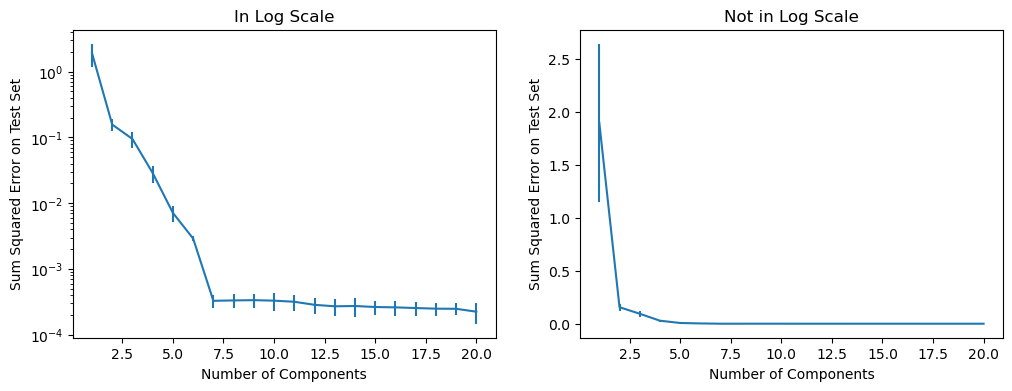

In [10]:
# Let's plot the results
plot_performance(gs, components)

<div class="alert alert-block alert-success">  
PCA/IA is working well! In log scale it is clear that the test set error is monotonically decreasing, which means the CV object will choose the maximum number of components as the optimum.  In practice, N ~ 5-7 seems reasonable.  
</div>

In [11]:
gs.best_params_ # Indeed, N = 20 is what the CV object chooses

{'pca_ia__n_components': 20}

In [12]:
filler = PCA_IA(
        n_components=5, 
        scale_x=True)

reconstructed_X = filler.fit_transform(
    missing_X, 
)
compare(raw_X, reconstructed_X, first=10)

Reconstructed	Original	Difference	Relative Err
5.346e-01	5.336e-01	1.006e-03	0.002
4.536e-01	4.541e-01	-4.500e-04	0.001
-3.142e-01	-3.164e-01	2.177e-03	0.007
-9.843e-01	-9.870e-01	2.786e-03	0.003
5.881e-01	5.859e-01	2.184e-03	0.004
-1.461e+00	-1.461e+00	2.373e-04	0.000
1.242e-01	1.236e-01	5.246e-04	0.004
-2.725e-01	-2.729e-01	4.817e-04	0.002
1.163e+00	1.162e+00	3.634e-04	0.000
1.230e+00	1.233e+00	-2.637e-03	0.002


<div class="alert alert-block alert-warning"> 
You can then use this in other pipelines.  You can specify the imputer without any hyperparameters in those cases, for example.
Below is an example of how you might do that when using a subsquent PLS-DA model. 
</div>

<pre>
<div class="alert alert-block alert-success"> 
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("pca_ia", PCA_IA(n_components=9, scale_x=False)),
    ("plsda", PLSDA(n_components=5, 
                    alpha=0.05,
                    scale_x=True, 
                    not_assigned='UNKNOWN',
                    style='soft', 
                   )
    )
])

# Specify hyperparameters associated with each step
param_grid = [{
    "pca_ia__n_components": np.arange(1, 10, 2)
    "plsda__n_components": np.arange(1, 10, 2),
    "plsda__alpha": [0.07, 0.05, 0.03, 0.01],
}]

# Create grid search cross-validation object
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    error_score=0,
    refit=True
)

# Train
_ = gs.fit(x_train, y_train)
</div>
</pre>

Iterative PLS (Missing X values)
---

PCA is an unsupervised approach and only looks at the feature matrix, X, to reconstruct the missing values. If we use PLS instead this becomes a supervised method, which now considers the response variable, y, in the reconstruction.

As stated in [1]:

> "For a PLS model, the IA is included into the PLS procedure as follows:
> 1. fill in missing elements with their initial estimates for fn=1:A (number of factors),
> 2. calculate the mean of X and of y,
> 3. center X and y,
> 4. calculate weights, scores and loadings,
> 5. substract the predicted X and y from the original X and y and go to step 4 end,
> 6. reconstruct X with the actual set of scores and loadings (and A factors),
> 7. fill in missing elements in X with their estimates and go to step 2 until convergence."

<h3>Fixed Number of Components</h3>

In [13]:
from pychemauth.preprocessing.missing import PLS_IA

In [14]:
itim = PLS_IA(
    n_components=3, 
    missing_values=np.nan, 
    scale_x=True,
    tol=1.0e-6, 
    max_iters=5000
)

In [15]:
reconstructed_X = itim.fit_transform(
    missing_X, 
    raw_y.reshape(-1,1)
)
compare(raw_X, reconstructed_X, first=10)

Reconstructed	Original	Difference	Relative Err
5.241e-01	5.336e-01	-9.544e-03	0.018
4.524e-01	4.541e-01	-1.746e-03	0.004
-3.107e-01	-3.164e-01	5.670e-03	0.018
-9.839e-01	-9.870e-01	3.119e-03	0.003
5.939e-01	5.859e-01	7.997e-03	0.014
-1.460e+00	-1.461e+00	1.315e-03	0.001
1.220e-01	1.236e-01	-1.664e-03	0.013
-2.738e-01	-2.729e-01	-8.213e-04	0.003
1.167e+00	1.162e+00	4.335e-03	0.004
1.245e+00	1.233e+00	1.249e-02	0.010


<h3>Unknown Number of Components</h3>

In [16]:
pipeline = sklearn.pipeline.Pipeline(steps=[
    ("pls_ia", PLS_IA(
        n_components=1, 
        scale_x=True)
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
components = np.arange(1, 10+1, 1)
param_grid = [{
    'pls_ia__n_components': components,
}]

# Let's use a simple grid search cross-validation stratgegy with 5-fold CV
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

# Fit the PLS_IA object
_ = gs.fit(
    missing_X, 
    raw_y.reshape(-1,1)
)

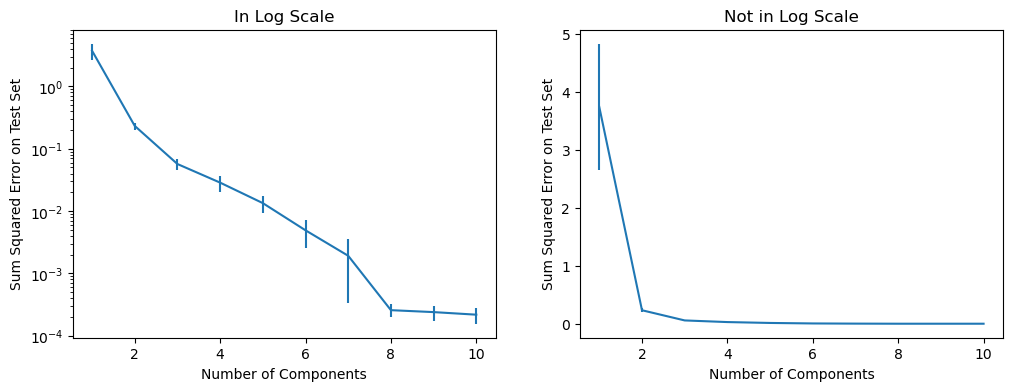

In [17]:
# Let's plot the results
plot_performance(gs, components)

<div class="alert alert-block alert-success">  
PLS/IA is also working well! In log scale it is clear that the test set error is monotonically decreasing, which means the CV object will choose the maximum number of components as the optimum.  In practice, N ~ 3-8 seems reasonable.  
</div>

In [18]:
gs.best_params_

{'pls_ia__n_components': 10}

In [19]:
filler = PLS_IA(
        n_components=8, 
        scale_x=True)

reconstructed_X = filler.fit_transform(
    missing_X, 
    raw_y.reshape(-1,1)
)
compare(raw_X, reconstructed_X, first=10)

Reconstructed	Original	Difference	Relative Err
5.346e-01	5.336e-01	9.237e-04	0.002
4.540e-01	4.541e-01	-1.330e-04	0.000
-3.163e-01	-3.164e-01	3.150e-05	0.000
-9.867e-01	-9.870e-01	3.173e-04	0.000
5.855e-01	5.859e-01	-3.667e-04	0.001
-1.461e+00	-1.461e+00	-5.981e-05	0.000
1.239e-01	1.236e-01	2.133e-04	0.002
-2.732e-01	-2.729e-01	-2.782e-04	0.001
1.162e+00	1.162e+00	-4.916e-04	0.000
1.233e+00	1.233e+00	3.452e-04	0.000


Below Limit of Detection (LOD)
---

<div class="alert alert-block alert-info">
Another commonly encounted case where imputation is necessary is when measurements are below an instrument's LOD. This data may be biased based on the instrument itself (e.g., could return a fixed value or have non-Gaussian behavior) and it is generally preferable to impute those value randomly to avoid introducing bias in models trained on this data.
</div>

<div class="alert alert-block alert-warning">
Data in the feature matrix (X) is assumed "missing" because it is
below the limit of detection (LOD).  <b>However, any values explicitly less than
    the LODs provided are also selected for imputation.</b> In both cases, random values
are chosen between 0 and the LOD (which must be provided by the user).
</div>

In [20]:
from pychemauth.preprocessing.missing import LOD

<h3>Missing values are only because < LOD</h3>
    
<div class="alert alert-block alert-info"> 
First, let's consider a feature matrix where values less than LOD have been reported as NaN.  We simply need to detect and impute.
</div>

In [21]:
# Hypothetical feature matrix
X = np.array(
    [
        [1.0, 2.0, 3.0, 4.0],
        [np.nan, 3.0, 2.0, np.nan],
        [5.0, 1.0, np.nan, 5.0],
        [2.0, 3.0, 4.0, 5.0]
    ]
)

# Hypothetical limit of detection for each column in the feature matrix
lod = np.array([0.01, 0.01, 1.0, 3.0])

In [22]:
imputer = LOD(
    lod, 
    missing_values=np.nan, 
    seed=42
)

# Each NaN is replaced with a random value < lod for each column
imputer.fit_transform(X)

array([[1.        , 2.        , 3.        , 4.        ],
       [0.00773956, 3.        , 2.        , 2.57579376],
       [5.        , 1.        , 0.43887844, 5.        ],
       [2.        , 3.        , 4.        , 5.        ]])

In [23]:
# However, any value less than LOD is automatically imputed so we don't technically need them to be flagged

X = np.array(
    [
        [1.0, 2.0, 3.0, 4.0],
        [0.001, 3.0, 2.0, 0.001],
        [5.0, 1.0, 0.001, 5.0],
        [2.0, 3.0, 4.0, 5.0]
    ]
)

imputer.transform(X)

array([[1.        , 2.        , 3.        , 4.        ],
       [0.00697368, 3.        , 2.        , 2.92686705],
       [5.        , 1.        , 0.09417735, 5.        ],
       [2.        , 3.        , 4.        , 5.        ]])

<h3>Missing values and < LOD are different</h3>
    
<div class="alert alert-block alert-warning"> 
It is also possible that we may encounter cases where some data is missing and some data is < LOD.  
In this case, we would may want to impute the missing data with PLS_IA or PCA_IA, but randomly impute the data that has been recorded, but is less than LOD.
</div>                                                                                                

In [24]:
# Now assume NaN is a missing value and there are other entries that are < LOD also present.
X = np.array(
    [
        [1.0, np.nan, 3.0, 4.0],
        [0.001, 3.0, 2.0, np.nan],
        [5.0, 1.0, np.nan, 5.0],
        [2.0, 3.0, 0.001, 5.0]
    ]
)

<div class="alert alert-block alert-danger">  
A naive imputer will replace BOTH the < LOD values and NaNs.
</div>

In [25]:
imputer = LOD(
    lod, 
    seed=42,
#     missing_values=np.nan 
)

imputer.fit_transform(X)

array([[1.00000000e+00, 4.38878440e-03, 3.00000000e+00, 4.00000000e+00],
       [7.73956049e-03, 3.00000000e+00, 2.00000000e+00, 2.82532044e-01],
       [5.00000000e+00, 1.00000000e+00, 8.58597920e-01, 5.00000000e+00],
       [2.00000000e+00, 3.00000000e+00, 6.97368029e-01, 5.00000000e+00]])

<div class="alert alert-block alert-warning">
Instead, we should ignore NaN values and let the imputer only work on the values explicitly less than LOD. One option is change the default value for missing_values to something else, e.g., -1. The other option is to specify this value as 'ignored.'
</div>

In [26]:
# Step 1: Impute < LOD values while ignoring the NaNs which will be handled later
imputer = LOD(
    lod, 
    ignore=np.nan, 
    seed=42
)
X_lod = imputer.fit_transform(X)
X_lod

array([[1.        ,        nan, 3.        , 4.        ],
       [0.00773956, 3.        , 2.        ,        nan],
       [5.        , 1.        ,        nan, 5.        ],
       [2.        , 3.        , 0.43887844, 5.        ]])

In [27]:
# Step 2: Now remove NaNs by doing imputation
itim = PCA_IA(
    n_components=1, 
    missing_values=np.nan, # NaN's were preserved during LOD imputation
    scale_x=True,
    tol=1.0e-6, 
    max_iters=5000
)
X_recon = itim.fit_transform(
    X_lod, 
)
X_recon

array([[ 1.        ,  3.64184538,  3.        ,  4.        ],
       [ 0.00773956,  3.        ,  2.        ,  4.3137826 ],
       [ 5.        ,  1.        , -2.32238208,  5.        ],
       [ 2.        ,  3.        ,  0.43887844,  5.        ]])

<div class="alert alert-block alert-warning"> 
Below is an example of using these two imputation methods together in a pipeline.
</div>

<pre>
<div class="alert alert-block alert-success"> 
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("lod", LOD(lod, ignore=np.nan, seed=42)),
    ("pca_ia", PCA_IA(n_components=9, scale_x=False)),
    ("plsda", PLSDA(n_components=5, 
                    alpha=0.05,
                    scale_x=True, 
                    not_assigned='UNKNOWN',
                    style='soft', 
                   )
    )
])

# Specify hyperparameters associated with each step
param_grid = [{
    "pca_ia__n_components": np.arange(1, 10, 2)
    "plsda__n_components": np.arange(1, 10, 2),
    "plsda__alpha": [0.07, 0.05, 0.03, 0.01],
}]

# Create grid search cross-validation object
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    error_score=0,
    refit=True
)

# Train
_ = gs.fit(x_train, y_train)
</div>
</pre>